In [55]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [56]:
data = pd.read_csv('sdwpf134_initial_kddcup.csv')
# data = data.drop(data.groupby('TurbID').tail(27).index)

In [52]:
data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,2.81,-2.00,16.61,30.95,148.0,0.03,0.03,0.03,-19.38,111.13
1,1,1,00:15,2.48,-4.30,16.38,30.83,148.0,0.03,0.03,0.03,-15.69,75.30
2,1,1,00:30,1.16,9.28,16.62,31.05,135.0,0.03,0.03,0.03,-2.50,9.54
3,1,1,00:45,0.92,14.38,16.13,31.20,148.0,0.04,0.04,0.03,-0.70,0.00
4,1,1,01:00,1.38,-4.28,15.12,29.52,148.0,89.68,89.69,89.50,-0.30,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90016,134,7,16:00,7.50,26.11,23.62,23.80,181.0,90.40,90.39,90.00,-0.30,0.00
90017,134,7,16:15,8.44,22.52,23.25,23.58,181.0,90.40,90.39,90.00,-0.30,0.00
90018,134,7,16:30,6.66,21.42,23.25,23.50,181.0,90.40,90.39,90.00,-0.30,0.00
90019,134,7,16:45,8.38,11.90,23.00,23.50,181.0,90.40,90.39,90.00,-0.30,0.00


In [36]:
data.describe()

,TurbID,Day,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
count,86430.000000,86430.000000,86430.000000,86430.000000,86430.000000,86430.000000,86430.000000,86430.000000,86430.000000,86430.000000,86430.000000,86430.000000
mean,67.500000,3.874419,5.402638,0.096762,37.129339,23.624256,246.297924,23.313990,23.313535,22.980165,-26.285178,371.511555
std,38.681615,1.942928,3.250940,30.147947,82.342960,10.685518,142.360729,37.327863,37.325183,37.034710,65.541048,425.759286
min,1.000000,1.000000,0.000000,-179.800000,-272.000000,-273.200000,-268.000000,-2.000000,-2.000000,-2.000000,-456.000000,-46.570000
25%,34.000000,2.000000,2.690000,-5.380000,14.940000,20.550000,154.000000,0.010000,0.010000,0.010000,-59.250000,0.000000
50%,67.500000,4.000000,5.020000,-0.600000,18.250000,23.630000,284.000000,0.040000,0.040000,0.040000,-19.380000,225.040000
75%,101.000000,6.000000,7.570000,4.880000,21.500000,27.020000,356.000000,17.770000,17.767500,17.250000,-0.300000,553.470000
max,134.000000,7.000000,18.790000,176.840000,396.000000,43.200000,592.000000,90.900000,90.900000,100.000000,186.000000,1598.100000


In [46]:
patv_min = min(data.Patv)
patv_max = max(data.Patv)

In [38]:
#lag feature
lag_1 = 1
lag_2 = 2
lag_3 = 3

col_name = data.columns.tolist()
col_name.insert(col_name.index('Wspd')+lag_1, 'wspd_lag1')
col_name.insert(col_name.index('Wspd')+lag_2, 'wspd_lag2')
col_name.insert(col_name.index('Wspd')+lag_3, 'wspd_lag3')
col_name.insert(col_name.index('Wdir')+lag_1, 'wdir_lag1')
col_name.insert(col_name.index('Wdir')+lag_2, 'wdir_lag2')
col_name.insert(col_name.index('Wdir')+lag_3, 'wdir_lag3')
col_name.insert(col_name.index('Etmp')+lag_1, 'etmp_lag1')
col_name.insert(col_name.index('Etmp')+lag_2, 'etmp_lag2')
col_name.insert(col_name.index('Etmp')+lag_3, 'etmp_lag3')
col_name.insert(col_name.index('Itmp')+lag_1, 'itmp_lag1')
col_name.insert(col_name.index('Itmp')+lag_2, 'itmp_lag2')
col_name.insert(col_name.index('Itmp')+lag_3, 'itmp_lag3')
col_name.insert(col_name.index('Prtv')+lag_1, 'prtv_lag1')
col_name.insert(col_name.index('Prtv')+lag_2, 'prtv_lag2')
col_name.insert(col_name.index('Prtv')+lag_3, 'prtv_lag3')
data = data.reindex(columns=col_name)

data['wspd_lag1'] = data['Wspd'].shift(lag_1)
data['wspd_lag2'] = data['Wspd'].shift(lag_2)
data['wspd_lag3'] = data['Wspd'].shift(lag_3)
data['wdir_lag1'] = data['Wdir'].shift(lag_1)
data['wdir_lag2'] = data['Wdir'].shift(lag_2)
data['wdir_lag3'] = data['Wdir'].shift(lag_3)
data['etmp_lag1'] = data['Etmp'].shift(lag_1)
data['etmp_lag2'] = data['Etmp'].shift(lag_2)
data['etmp_lag3'] = data['Etmp'].shift(lag_3)
data['itmp_lag1'] = data['Itmp'].shift(lag_1)
data['itmp_lag2'] = data['Itmp'].shift(lag_2)
data['itmp_lag3'] = data['Itmp'].shift(lag_3)
data['prtv_lag1'] = data['Prtv'].shift(lag_1)
data['prtv_lag2'] = data['Prtv'].shift(lag_2)
data['prtv_lag3'] = data['Prtv'].shift(lag_3)

In [ ]:
# 填充
# avg_wspd = np.mean(data['Wspd'])
# data['wspd_lag1'].fillna(value=None, method=None, axis=None, inplace=False, limit=None, downcast=None, **kwargs)
# data['wspd_lag2'].fillna(value=None, method=None, axis=None, inplace=False, limit=None, downcast=None, **kwargs)
# data['wspd_lag3'].fillna(value=None, method=None, axis=None, inplace=False, limit=None, downcast=None, **kwargs)


In [39]:
# 或者 去掉lag的行
time_len = data.Tmstamp.nunique()*data.Day.nunique()
for i in range(data.TurbID.nunique()):
    data = data.drop([i*time_len+lag_1-1,i*time_len+lag_2-1,i*time_len+lag_3-1])

In [4]:
# 增加每周时间index
timelength = data['Tmstamp'].nunique()*data['Day'].nunique()
tmp = []
for i in range(data['TurbID'].nunique()):
    tmp  = tmp + list(range(timelength))
data['time_week'] = tmp

In [5]:
# 增加每日时间index
tmp = []
tmstamp = data['Tmstamp'][:672].tolist()
tmstamp_num = []
for i in tmstamp:
    tmstamp_num.append(int(i[:2])*60+int(i[3:]))
for i in range(data['TurbID'].nunique()):
    tmp  = tmp + tmstamp_num
data['time_day'] = tmp

In [5]:
# 求每台机器的风机的patv的均值

turbid_unique = data.TurbID.unique()
turbid_nunique = data.TurbID.value_counts().to_dict()
turbid_dic = {}
for i in range(len(turbid_unique)):
    turbid_dic[turbid_unique[i]] = 0
for i in range(len(data.TurbID)):
    turbid_dic[data.TurbID[i]] += data.Patv[i]
for k in turbid_dic.keys():
    turbid_dic[k] = turbid_dic[k]/turbid_nunique[k]
turbid_avg_patv = []
for i in range(len(data.TurbID)):
    turbid_avg_patv.append(turbid_dic[data.TurbID[i]])
data['turbid_avg_patv'] = turbid_avg_patv

In [6]:
avg_patv = pd.Series(data['turbid_avg_patv'].unique().tolist())

In [10]:
from tsfresh import extract_features
extracted_features = extract_features(data, column_id="TurbID", column_sort="time_week")

Feature Extraction: 100%|██████████| 99/99 [02:42<00:00,  1.64s/it]


In [11]:
pd.merge(data, extracted_features, left_on='TurbID', right_index=True, how='left', sort=True)

,TurbID,Day,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,...,Itmp__permutation_entropy__dimension_6__tau_1,Itmp__permutation_entropy__dimension_7__tau_1,Itmp__query_similarity_count__query_None__threshold_0.0,"Itmp__matrix_profile__feature_""min""__threshold_0.98","Itmp__matrix_profile__feature_""max""__threshold_0.98","Itmp__matrix_profile__feature_""mean""__threshold_0.98","Itmp__matrix_profile__feature_""median""__threshold_0.98","Itmp__matrix_profile__feature_""25""__threshold_0.98","Itmp__matrix_profile__feature_""75""__threshold_0.98",Itmp__mean_n_absolute_max__number_of_maxima_7
0,1,1,2.81,-2.00,16.61,30.95,148.0,0.03,0.03,0.03,...,4.507525,5.116151,NaN,1.727447,5.724445,3.276490,3.200392,2.531573,4.015738,36.250000
1,1,1,2.48,-4.30,16.38,30.83,148.0,0.03,0.03,0.03,...,4.507525,5.116151,NaN,1.727447,5.724445,3.276490,3.200392,2.531573,4.015738,36.250000
2,1,1,1.16,9.28,16.62,31.05,135.0,0.03,0.03,0.03,...,4.507525,5.116151,NaN,1.727447,5.724445,3.276490,3.200392,2.531573,4.015738,36.250000
3,1,1,0.92,14.38,16.13,31.20,148.0,0.04,0.04,0.03,...,4.507525,5.116151,NaN,1.727447,5.724445,3.276490,3.200392,2.531573,4.015738,36.250000
4,1,1,1.38,-4.28,15.12,29.52,148.0,89.68,89.69,89.50,...,4.507525,5.116151,NaN,1.727447,5.724445,3.276490,3.200392,2.531573,4.015738,36.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90043,134,7,9.94,1.90,22.75,22.63,181.0,90.40,90.39,90.00,...,4.213632,4.760144,NaN,2.063633,6.510020,3.591736,3.565875,2.733444,4.229401,26.841429
90044,134,7,9.94,1.90,22.75,22.63,181.0,90.40,90.39,90.00,...,4.213632,4.760144,NaN,2.063633,6.510020,3.591736,3.565875,2.733444,4.229401,26.841429
90045,134,7,9.94,1.90,22.75,22.63,181.0,90.40,90.39,90.00,...,4.213632,4.760144,NaN,2.063633,6.510020,3.591736,3.565875,2.733444,4.229401,26.841429
90046,134,7,9.94,1.90,22.75,22.63,181.0,90.40,90.39,90.00,...,4.213632,4.760144,NaN,2.063633,6.510020,3.591736,3.565875,2.733444,4.229401,26.841429


In [13]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, data['turbid_avg_patv'].unique())

In [14]:
features_filtered

,Patv__large_standard_deviation__r_0.25,"turbid_avg_patv__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)","turbid_avg_patv__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)","turbid_avg_patv__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)","turbid_avg_patv__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)","turbid_avg_patv__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)","turbid_avg_patv__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)","turbid_avg_patv__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)","turbid_avg_patv__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)","turbid_avg_patv__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)",...,"Pab1__fft_coefficient__attr_""imag""__coeff_19",Pab2__cid_ce__normalize_True,"Wspd__fft_coefficient__attr_""angle""__coeff_67","Etmp__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)","Ndir__fft_coefficient__attr_""abs""__coeff_96","Prtv__fft_coefficient__attr_""real""__coeff_79","Wspd__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","Pab3__fft_coefficient__attr_""imag""__coeff_18","Prtv__fft_coefficient__attr_""abs""__coeff_24","Pab3__fft_coefficient__attr_""imag""__coeff_22"
1,1.0,0.014333,672.671026,654.168840,205.913411,0.014333,619.959658,647.477839,271.334199,0.079836,...,-439.310484,13.064198,159.425771,24.539489,398.187909,-171.776585,0.012265,148.809137,1649.873892,-2147.998852
2,1.0,0.013882,651.535867,633.615014,199.443662,0.013882,600.480677,627.134244,262.808945,0.077327,...,-890.956685,12.044259,125.232030,27.892361,485.882449,-888.765996,0.007982,160.750213,1157.175557,-958.889373
3,1.0,0.013571,636.936452,619.417164,194.974590,0.013571,587.025291,613.081613,256.920003,0.075595,...,-117.852686,15.020072,110.807310,26.617091,200.280639,-801.418575,0.007319,-895.443839,655.959315,-1826.498078
4,1.0,0.013258,622.253930,605.138493,190.480078,0.013258,573.493311,598.948988,250.997538,0.073852,...,-111.391106,14.076871,135.726152,28.045608,148.593517,-1196.955282,0.015101,-206.419323,1580.398224,-2534.897459
5,1.0,0.013390,628.431693,611.146334,192.371172,0.013390,579.186976,604.895378,253.489453,0.074585,...,-850.157490,12.626941,-174.067245,476.634289,416.654162,-1550.361863,0.010470,-551.837967,840.647531,-472.431834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1.0,0.013152,617.242645,600.265047,188.946058,0.013152,568.874717,594.125388,248.976145,0.073257,...,-354.122073,13.624959,101.399227,23.190364,257.060219,-777.710134,0.009096,156.517085,93.984053,-1636.882603
131,1.0,0.011163,523.908081,509.497701,160.375125,0.011163,482.853969,504.286433,211.327936,0.062180,...,702.770860,13.638960,165.241284,24.108863,267.830005,-1316.799025,0.010311,-202.124234,1419.672932,-1881.180211
132,0.0,0.012423,583.020302,566.984008,178.470150,0.012423,537.334080,561.184756,235.171935,0.069196,...,-353.767329,13.478188,127.087476,480.228161,628.539901,-1138.382083,0.006186,-642.971356,1073.522138,-1516.053776
133,0.0,0.010778,505.839115,491.925732,154.843978,0.010778,466.200911,486.894194,204.039487,0.060035,...,94.582666,12.618522,76.455233,20.742876,456.155394,-1159.912199,0.006686,461.368723,1052.792312,-1028.972069


In [15]:
data = features_filtered

In [8]:
from tsfresh import extract_relevant_features

features_filtered_direct = extract_relevant_features(data, avg_patv,
                            column_id="TurbID", column_sort="time_week")

ValueError: The following ids are in the time series container but are missing in y: {134}

In [9]:
features_filtered_direct

NameError: name 'features_filtered_direct' is not defined

In [118]:
#风速自减
wspd_diff = [0]
for i in range(len(data['Wspd'])):
    if i == 0:
        continue
    wspd_diff.append(data['Wspd'][i] - data['Wspd'][i-1])
data['wspd_diff'] = wspd_diff

In [119]:
#风向自减
wdir_diff = [0]
for i in range(len(data['Wdir'])):
    if i == 0:
        continue
    wdir_diff.append(data['Wdir'][i] - data['Wdir'][i-1])
data['wdir_diff'] = wdir_diff

In [120]:
#温度自减
etmp_diff = [0]
for i in range(len(data['Etmp'])):
    if i == 0:
        continue
    etmp_diff.append(data['Etmp'][i] - data['Etmp'][i-1])
data['etmp_diff'] = etmp_diff

itmp_diff = [0]
for i in range(len(data['Itmp'])):
    if i == 0:
        continue
    itmp_diff.append(data['Itmp'][i] - data['Itmp'][i-1])
data['itmp_diff'] = itmp_diff

KeyError: 'itmp'

In [ ]:
#prtv自减
prtv_diff = [0]
for i in range(len(data['Prtv'])):
    if i == 0:
        continue
    prtv_diff.append(data['Prtv'][i] - data['Prtv'][i-1])
data['prtv_diff'] = prtv_diff

In [ ]:
#分桶 to be done

In [27]:
# 求相同温度下的风机的patv的均值

etmp_unique = data.Etmp.unique()
itmp_unique = data.Itmp.unique()


etmp_nunique = data.Etmp.value_counts().to_dict()
itmp_nunique = data.Itmp.value_counts().to_dict()


# print(etmp_nunique)

etmp_dic = {}
itmp_dic = {}


for i in range(len(etmp_unique)):
    etmp_dic[etmp_unique[i]] = 0
for i in range(len(itmp_unique)):
    itmp_dic[itmp_unique[i]] = 0

    
# 求和
for i in range(len(data.Etmp)):
    etmp_dic[data.Etmp[i]] += data.Patv[i]
for i in range(len(data.Itmp)):
    itmp_dic[data.Itmp[i]] += data.Patv[i]


#计算均值
for k in etmp_dic.keys():
    etmp_dic[k] = etmp_dic[k]/etmp_nunique[k]
for k in itmp_dic.keys():
    itmp_dic[k] = itmp_dic[k]/itmp_nunique[k]

    
etmp_avg_patv = []
itmp_avg_patv = []


for i in range(len(data.Etmp)):
    etmp_avg_patv.append(etmp_dic[data.Etmp[i]])
for i in range(len(data.Itmp)):
    itmp_avg_patv.append(itmp_dic[data.Itmp[i]])

    
data['etmp_avg_patv'] = etmp_avg_patv
data['itmp_avg_patv'] = itmp_avg_patv


In [ ]:
# 求相同风速下的风机的patv的均值

wspd_unique = data.Wspd.unique()
wspd_nunique = data.Wspd.value_counts().to_dict()
wspd_dic = {}
for i in range(len(wspd_unique)):
    wspd_dic[wspd_unique[i]] = 0
for i in range(len(data.Wspd)):
    wspd_dic[data.Wspd[i]] += data.Patv[i]
for k in wspd_dic.keys():
    wspd_dic[k] = wspd_dic[k]/wspd_nunique[k]
wspd_avg_patv = []
for i in range(len(data.Wspd)):
    wspd_avg_patv.append(wspd_dic[data.Wspd[i]])
data['wspd_avg_patv'] = wspd_avg_patv

In [601]:
#Patv挪至第一列，方便套其他的回归模型

data_patv = data.Patv
data = data.drop('Patv',axis=1)
data.insert(0,'Patv',data_patv)

In [57]:
# 去掉不需要的列

# data = data.drop('TurbID',axis=1)
data = data.drop('Tmstamp',axis=1)
# data = data.drop('timestamp',axis=1)

In [58]:
#划分数据集

train_data = data.loc[data['Day'] != 7]
test_data = data.loc[data['Day'] == 7]

train_feat = train_data.drop('Patv',axis=1)
train_label = train_data['Patv']
test_feat = test_data.drop('Patv',axis=1)
test_label = test_data['Patv']
print(len(test_data))

12864


In [36]:
# print(train_feat[:1])
# print(test_feat[:1])
# print(test_label[-10:])

In [26]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
params = {'num_leaves': 80, 
          'max_depth': 7,
          'learning_rate': 0.3,
          "boosting": "gbdt",
          "feature_fraction": 0.3,  
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 1,
          "lambda_l1": 0.3,             #l1
          'lambda_l2': 0.01,     #l2
          "verbosity": -1,
          "nthread": -1,                
          'metric': 'rmse', 
          "random_state": 1, 
          'n_estimators': 10000,
          }

test = test_feat.copy()

NFOLD = 5
group_list = []
for i in range(NFOLD):
    if i < NFOLD-1:
        tmp = [i] * int(len(train_label)/NFOLD)
    else:
        tmp = [i] * (len(train_label) - int(len(train_label)/NFOLD) * (NFOLD-1))
    group_list += tmp

groups = np.array(group_list)
group_kfold = GroupKFold(n_splits=5)
# group_kfold.get_n_splits(train_feat, train_label, groups)

for train_index, test_index in group_kfold.split(train_feat, train_label, groups):
    X_train, X_validate = train_feat.iloc[train_index,:], train_feat.iloc[test_index,:]
    label_train, label_validate = train_label.iloc[train_index], train_label.iloc[test_index]
    dtrain = lgb.Dataset(X_train, label_train)
    dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
    
    gbm = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=dvalid,early_stopping_rounds=50)
    
    preds_last = gbm.predict(test, num_iteration=gbm.best_iteration)
    cv_pred += gbm.predict(test, num_iteration=gbm.best_iteration)
    valid_best += gbm.best_score['valid_0']['rmse']
    
cv_pred /= NFOLDS
valid_best /= NFOLDS

[    0     1     2 ... 61741 61742 61743]
[1]	valid_0's rmse: 355.111
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 265.784


KeyboardInterrupt: 

In [59]:
gbm = lgb.LGBMRegressor(objective='regression', num_leaves=80, learning_rate=0.07, n_estimators=300, max_depth=7)
gbm.fit(train_feat, train_label, eval_set=[(test_feat, test_label)], eval_metric='l2', early_stopping_rounds=15)

[1]	valid_0's l2: 71566.4
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l2: 62719.4
[3]	valid_0's l2: 55146.4
[4]	valid_0's l2: 48845.5
[5]	valid_0's l2: 43164.7
[6]	valid_0's l2: 38424.7
[7]	valid_0's l2: 34273.9
[8]	valid_0's l2: 30704.7
[9]	valid_0's l2: 27589.3
[10]	valid_0's l2: 25003.8
[11]	valid_0's l2: 22693.4
[12]	valid_0's l2: 20797.7
[13]	valid_0's l2: 19053.9
[14]	valid_0's l2: 17621.7
[15]	valid_0's l2: 16344.3
[16]	valid_0's l2: 15268.8
[17]	valid_0's l2: 14329.9
[18]	valid_0's l2: 13513.2
[19]	valid_0's l2: 12796.3
[20]	valid_0's l2: 12154.9
[21]	valid_0's l2: 11596.3
[22]	valid_0's l2: 11101.3
[23]	valid_0's l2: 10688.4
[24]	valid_0's l2: 10410.8
[25]	valid_0's l2: 10116.5
[26]	valid_0's l2: 9931.54
[27]	valid_0's l2: 9772.74
[28]	valid_0's l2: 9589.9
[29]	valid_0's l2: 9408.79
[30]	valid_0's l2: 9288.37
[31]	valid_0's l2: 9166.86
[32]	valid_0's l2: 9048.49
[33]	valid_0's l2: 8961.64
[34]	valid_0's l2: 8948.16
[35]	valid_0's l2: 8842.9
[36]	

LGBMRegressor(learning_rate=0.07, max_depth=7, n_estimators=300, num_leaves=80,
              objective='regression')

In [60]:
#验证

# y_pred = gbm.predict(test_feat, num_iteration=gbm.best_iteration_)
y_pred = gbm.predict(test_feat)

for i in range(len(y_pred)):
    if y_pred[i] < 0:
        y_pred[i] = 0
    if y_pred[i] > patv_max:
        y_pred[i] = patv_max

# 模型评估
print('The rmse of prediction is:', mean_squared_error(test_label, y_pred) ** 0.5)

# 模型评估
print('The mse of prediction is:', mean_squared_error(test_label, y_pred))

# 特征重要度
print('{}\nFeature importances:{}'.format([column for column in train_feat], list(gbm.feature_importances_)))

The rmse of prediction is: 74.82144409783011
The mse of prediction is: 5598.248496884717
['TurbID', 'Day', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv']
Feature importances:[1579, 741, 2048, 681, 1064, 701, 865, 976, 467, 434, 2374]


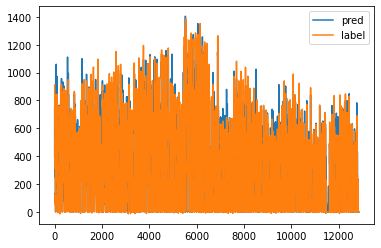

In [11]:
plt.plot(range(len(y_pred)), y_pred,label='pred')
plt.plot(range(len(test_label)), test_label, label='label')
plt.legend()